In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim
import math
import numpy as np
from tn import *
from tnale_nn import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

cuda:0


# Model setup

## Model definitions
We test different tensor decompositions methods by training a fully connected network model over the MNIST dataset.
The test model has layers [784, 320, 100, 10]

In [2]:
# Define the LeNet-300-100 model
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.l1 = nn.Linear(784, 180)
        self.l2 = nn.Linear(180, 100)
        self.l3 = nn.Linear(100, 10)
        
        self.classifier = nn.Sequential(
            self.l1,
            nn.ReLU(),
            self.l2,
            nn.ReLU(),
            self.l3
        )
    def get_name(self):
        return "LeNet"

    def forward(self, x):
        x = self.flatten(x)
        x = self.classifier(x)
        return x
    def get_matrix_data(self):
        return [self.l1.weight.data, self.l2.weight.data, self.l3.weight.data]
    

# Training functions

## Training helper functions

In [3]:
def evaluate_validation_set(model, validation_loader, device):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    with torch.no_grad():  # Disable gradient computation
        for x_val, y_val in validation_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            outputs = model(x_val)
            _, predicted = torch.max(outputs.data, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()

    accuracy = correct / total
    return accuracy


def show_example_batch(train_data):
    # Get the first batch
    train_loader, valid_loader = train_data
    
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    
    # Plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    plot_size=20
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx].numpy()), cmap='gray')
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(str(labels[idx].item()))
    plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
def get_train_data():
    transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,)),
                                  ])
    # Download and load the training data
    trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
    validation_size = 0.10
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    # Calculate the number of data points in the validation set
    split = int(np.floor(validation_size * num_train))
    print(split)
    
    # Train_idx => Imatges per entrenar
    # Valid_idx => Imatges per verificar i comprovar el model
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # Create data samplers
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)
    
    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=valid_sampler)

    return train_loader, valid_loader

## Train model function

In [4]:
def train_model(model, device, train_data, learning_rate=1.2e-3, batch_size=60, epochs=10):
    losses = []
    accuracy_list = []
    val_accuracy_list = []
    grad_norms = []
    print("Training model")
    print(model)

    model.train()
    train_loader, valid_loader = train_data
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #for param in model.parameters():
    #    print(param)
    # Validation Calculation
    val_check_iter = 3
    iterations_per_epoch = len(train_loader)
    print(len(train_loader))
    print(len(valid_loader))
    
    for epoch in range(epochs):
        for i, (x_batch, y_batch) in enumerate(train_loader):
            # Move data to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

    
            optimizer.zero_grad()
            output = model(x_batch)
            loss = nn.CrossEntropyLoss()(output, y_batch)
            loss.backward()
    
    
            # Calculate and store gradient norm
            total_grad_norm = torch.sqrt(sum(p.grad.norm()**2 for p in model.parameters() if p.grad is not None))
            grad_norms.append(total_grad_norm.item())
    
            optimizer.step()
    
            # Store the loss
            losses.append(loss.item())
    
            # Store the accuracy 
            _, argmax = torch.max(output, 1)
            accuracy = (y_batch == argmax.squeeze()).float().mean()
            accuracy_list.append(accuracy)
    
            if i % int(len(train_loader) / 50) == 0:
                print(".", end='')
    
            if i % int(len(train_loader) / val_check_iter) == 0:
                # Calculate validation accuracy at the end of each epoch
                val_accuracy = evaluate_validation_set(model, valid_loader, device)
                val_accuracy_list.append(val_accuracy)
                
                # Calculate average loss and accuracy over an epoch
                avg_loss = torch.mean(torch.tensor(losses[-len(train_loader):]))
                avg_accuracy = torch.mean(torch.tensor(accuracy_list[-len(train_loader):]))
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss.item():.4f}, Accuracy: {avg_accuracy.item():.4f}, Val Accuracy: {val_accuracy:.4f}')
        #print(output.max(), output.min())
    infos = {
        "losses": losses,
        "accuracy_list": accuracy_list,
        "grad_norms": grad_norms,
        "val_accuracy_list": val_accuracy_list,
        "iterations_per_epoch": iterations_per_epoch,
        "model_name": model.get_name()
    }
    return infos

## Show training results function

In [5]:
def show_training_infos(training_infos, epochs):
    
    average_window = 200
    infos = []
    for training_info in training_infos:
        losses = torch.tensor(training_info["losses"]).cpu().numpy()
        accuracy_list = torch.tensor(training_info["accuracy_list"]).cpu().numpy()
        grad_norms = torch.tensor(training_info["grad_norms"]).cpu().numpy()
        val_accuracy_list = training_info["val_accuracy_list"]
        iterations_per_epoch = training_info["iterations_per_epoch"]

        average_losses = [np.mean(losses[i-average_window:i]) for i in range(0, len(losses), average_window)]
        avg_accuracy_list = [np.mean(accuracy_list[i-average_window:i]) for i in range(0, len(accuracy_list), average_window)]
        avg_grad_norms = [np.mean(grad_norms[i-average_window:i]) for i in range(0, len(grad_norms), average_window)]

        iterations = np.arange(len(average_losses)) * average_window
        x_iterations = np.arange(0, iterations_per_epoch * epochs,(iterations_per_epoch * epochs) / len(val_accuracy_list))
        infos.append({
            "name": training_info["model_name"],
            "iterations": iterations,
            "average_losses": average_losses,
            "avg_grad_norms": avg_grad_norms,
            "avg_accuracy_list": avg_accuracy_list,
            "val_accuracy_list": val_accuracy_list,
            "x_iterations": x_iterations
        })
    
    # Plotting the loss curve (average, with max and min as error bands)
    plt.figure(figsize=(10, 4))
    plt.clf()
    for info in infos:
        plt.plot(info["iterations"], info["average_losses"], label=info["name"])
    
    plt.ylim(0, 0.5)
    
    plt.title('Training Loss Curve Average')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('results/nn/results_1.png')
    plt.show()
    
    # Plotting the gradient norm curve
    plt.clf()
    for info in infos:
        plt.plot(info["iterations"], info["avg_grad_norms"], label=info["name"])
    plt.title('Gradient Norm Curve Average')
    plt.xlabel('Iterations')
    plt.ylabel('Gradient Norm')
    plt.legend()
    plt.savefig('results/nn/results_2.png')
    plt.show()
    
    # Plotting the accuracy curve (average, with max and min as error bars)
    plt.clf()
    for info in infos:
        plt.plot(info["iterations"], info["avg_accuracy_list"], label=info["name"])
    plt.title('Training Accuracy Curve Average')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.savefig('results/nn/results_3.png')
    plt.show()
    plt.clf()
    # Zoom to 0.9 to 1.0 range
    plt.ylim(0.9, 1.0)
    
    # Plotting the validation accuracy curve
    x_iterations = np.arange(0, iterations_per_epoch * epochs,(iterations_per_epoch * epochs) / len(val_accuracy_list))
    plt.subplot(1, 2, 2)
    for info in infos:
        plt.plot(info["x_iterations"], info["val_accuracy_list"], label=info["name"])
    plt.title('Validation Accuracy Curve Average')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()

    # Zoom to 0.94 to 1.0 range
    plt.ylim(0.94, 1.0)
    
    plt.tight_layout()
    plt.savefig('results/nn/results_4.png')
    plt.show()

## Model test function

In [6]:
# Test the model
def test_model(model):
    model.eval()
    test_loss = 0
    correct = 0
    print(model)
    
    # Download and load the test data
    testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
    test_loader = DataLoader(testset, batch_size=64, shuffle=True)
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
    
            output = model(x_batch)
            test_loss += nn.CrossEntropyLoss()(output, y_batch).item()
    
            _, argmax = torch.max(output, 1)
            correct += (y_batch == argmax.squeeze()).float().sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    
    print(f'Test loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Actual training

In [7]:
model = LeNet()
model.to(device)
train_data = get_train_data()

epochs = 15
training_infos = []
# train pretraining model
training_infos.append(train_model(model, device, train_data, epochs=epochs))

6000
Training model
LeNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=784, out_features=180, bias=True)
  (l2): Linear(in_features=180, out_features=100, bias=True)
  (l3): Linear(in_features=100, out_features=10, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=180, bias=True)
    (1): ReLU()
    (2): Linear(in_features=180, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
844
94
.....................................................Epoch 1/15, Loss: 0.2473, Accuracy: 0.9251, Val Accuracy: 0.9567
....................................................Epoch 2/15, Loss: 0.1058, Accuracy: 0.9669, Val Accuracy: 0.9600
....................................................Epoch 3/15, Loss: 0.0728, Accuracy: 0.9770, Val Accuracy: 0.9730
....................................................Epoch 4/15, Loss: 0.0573, Accuracy: 0.9817, Val Accuracy: 0.9722
..................

In [8]:
G1 = nx.Graph()
G2 = nx.Graph()
G3 = nx.Graph()
G1.add_edges_from([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 1]])
G2.add_edges_from([[1, 2], [2, 3], [3, 4], [4, 5], [5, 1]])
G3.add_edges_from([[1, 2], [2, 3], [3, 4], [4, 1]])
#R1 = [14,14,14,14,14,14,14]
#R2 = [10,10,10,10,10]
#R3 = [7,7,7, 7]

R1 = [7,7,7,7,7,7,7]
R2 = [10,10,10,10,10]
R3 = [7,7,7,7]

S1 = [7,7,4,4]
S2 = [4,9,5]
S3 = [10, 10]
S4 = [2, 5]

m2 = LeNetTN("LeNetTN", [G1, G2, G3], [R1, R2, R3], [S1, S2, S3, S4])
print("CR: " + str(m2.get_cr()))
print("OR: " + str(m2.n_info["ori_params"] + 280))
print("PA: " + str(m2.n_info["t_params"] + 280))
train_data = get_train_data()
training_infos.append(train_model(m2, device, train_data, epochs=epochs))

CR: 22.60624029366088
OR: 160400
PA: 7363
6000
Training model
LeNetTN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): TNLinearLayer(
    (layer): TN(
      (params): ParameterDict(
          (1): Parameter containing: [torch.cuda.FloatTensor of size 7x7x7 (cuda:0)]
          (2): Parameter containing: [torch.cuda.FloatTensor of size 7x7x7 (cuda:0)]
          (3): Parameter containing: [torch.cuda.FloatTensor of size 4x7x7 (cuda:0)]
          (4): Parameter containing: [torch.cuda.FloatTensor of size 4x7x7 (cuda:0)]
          (5): Parameter containing: [torch.cuda.FloatTensor of size 4x7x7 (cuda:0)]
          (6): Parameter containing: [torch.cuda.FloatTensor of size 9x7x7 (cuda:0)]
          (7): Parameter containing: [torch.cuda.FloatTensor of size 5x7x7 (cuda:0)]
      )
    )
  )
  (l2): TNLinearLayer(
    (layer): TN(
      (params): ParameterDict(
          (1): Parameter containing: [torch.cuda.FloatTensor of size 4x10x10 (cuda:0)]
          (2): Parameter containing: [tor

In [9]:
# l = []
#m = LeNetTNALE()
#m.to(device)

#train_data = get_train_data()
#l = m.pretrain(train_data[1])
#print(l)
#better_model = LeNetTNALE(G1=l[0], R1=l[1], G2=l[2], R2=l[3], G3=l[4], R3 = l[5])

# train pretraining model
#training_infos.append(train_model(better_model, device, train_data, epochs=epochs))
plt.clf()
# show_training_infos(training_infos, epochs)
print("CR: " + str(m2.get_cr()))
print("OR: " + str(m2.n_info["ori_params"] + 280))
print("PA: " + str(m2.n_info["t_params"] + 280))

CR: 22.60624029366088
OR: 160400
PA: 7363


<Figure size 640x480 with 0 Axes>

0.10468135043375802
[7, 2, 7, 7, 7, 7, 7]
0.10467874003237401
[7, 2, 2, 7, 7, 7, 7]
0.10434153037963874
[7, 2, 2, 2, 7, 7, 7]
0.10367793463220364
[7, 2, 2, 2, 2, 7, 7]
0.10139653910154212
[7, 2, 2, 2, 2, 2, 7]
0.10068369277221202
[7, 2, 2, 2, 2, 2, 2]
GGGGGGGGGGGGGGGGGGGGG.
Iter 0 done
R: [2, 2, 2, 2, 2, 2]
G edges: [(1, 7), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]
.GGGGGG0.10017687480913165
[2, 2, 2, 2, 2, 2, 1]
0.10012477955299295
[2, 2, 2, 2, 2, 2, 1]
GGGGGGGGG0.10009792044099057
[2, 2, 2, 2, 2, 2, 1]
GGG.
Iter 1 done
R: [2, 2, 2, 2, 2, 2, 1]
G edges: [(1, 7), (2, 3), (3, 4), (3, 7), (4, 5), (5, 6), (6, 7)]
..
Iter 0 done
R: [2, 2, 2, 2, 2, 2, 1]
G edges: [(1, 7), (2, 3), (3, 4), (3, 7), (4, 5), (5, 6), (6, 7)]
..
Iter 1 done
R: [2, 2, 2, 2, 2, 2, 1]
G edges: [(1, 7), (2, 3), (3, 4), (3, 7), (4, 5), (5, 6), (6, 7)]
..
Iter 2 done
R: [2, 2, 2, 2, 2, 2, 1]
G edges: [(1, 7), (2, 3), (3, 4), (3, 7), (4, 5), (5, 6), (6, 7)]
..
Iter 3 done
R: [2, 2, 2, 2, 2, 2, 1]
G edges: [(1, 7), (2, 3),

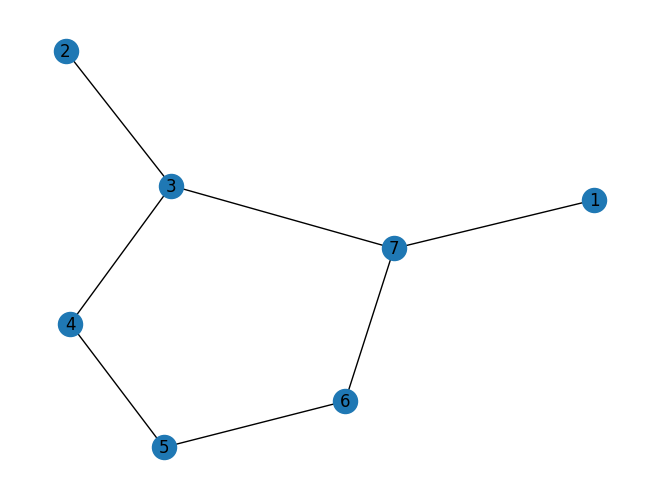

[2, 2, 2, 2, 2, 2, 1]
0.25403180311091955
[5, 10, 10, 10, 10]
0.22442140657278636
[5, 5, 10, 10, 10]
0.20205008275359498
[5, 5, 5, 10, 10]
0.17063790533777684
[5, 5, 5, 5, 10]
0.14576502977194405
[5, 5, 5, 5, 5]
GGGGGGGGGG.
0.12083333333333333
[5, 5, 5, 1]
0.1088888888888889
[5, 5, 1, 1]
0.10333333333333333
[5, 1, 1, 1]
Iter 0 done
R: [5, 1, 1, 1]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4)]
0.10138888888888889
[1, 1, 1, 1]
.GGGGGGGGGG.
Iter 1 done
R: [1, 1, 1, 1]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4)]
..
Iter 0 done
R: [1, 1, 1, 1]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4)]
..
Iter 1 done
R: [1, 1, 1, 1]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4)]
..
Iter 2 done
R: [1, 1, 1, 1]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4)]
..
Iter 3 done
R: [1, 1, 1, 1]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4)]
..
Iter 4 done
R: [1, 1, 1, 1]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4)]
FOUND:::


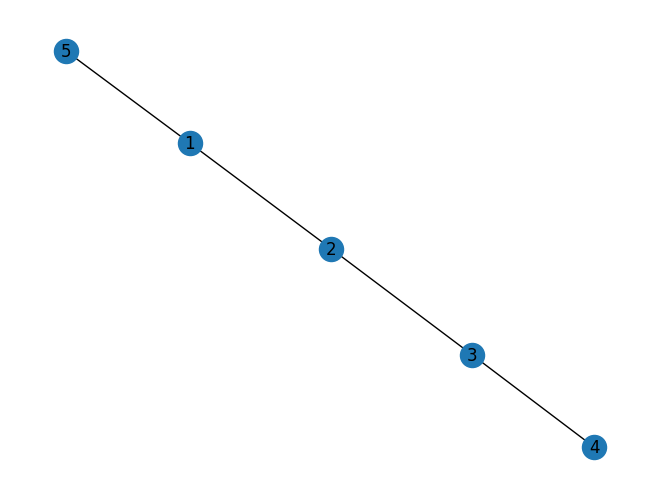

[1, 1, 1, 1]
CR: 107.39101274312542
OR: 160400
PA: 1771
6000
Training model
LeNetTN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): TNLinearLayer(
    (layer): TN(
      (params): ParameterDict(
          (1): Parameter containing: [torch.cuda.FloatTensor of size 7x2 (cuda:0)]
          (2): Parameter containing: [torch.cuda.FloatTensor of size 7x2 (cuda:0)]
          (3): Parameter containing: [torch.cuda.FloatTensor of size 4x2x2x2 (cuda:0)]
          (4): Parameter containing: [torch.cuda.FloatTensor of size 4x2x2 (cuda:0)]
          (5): Parameter containing: [torch.cuda.FloatTensor of size 4x2x2 (cuda:0)]
          (6): Parameter containing: [torch.cuda.FloatTensor of size 9x2x1 (cuda:0)]
          (7): Parameter containing: [torch.cuda.FloatTensor of size 5x2x2x1 (cuda:0)]
      )
    )
  )
  (l2): TNLinearLayer(
    (layer): TN(
      (params): ParameterDict(
          (1): Parameter containing: [torch.cuda.FloatTensor of size 4x1x1 (cuda:0)]
          (2): Parameter cont

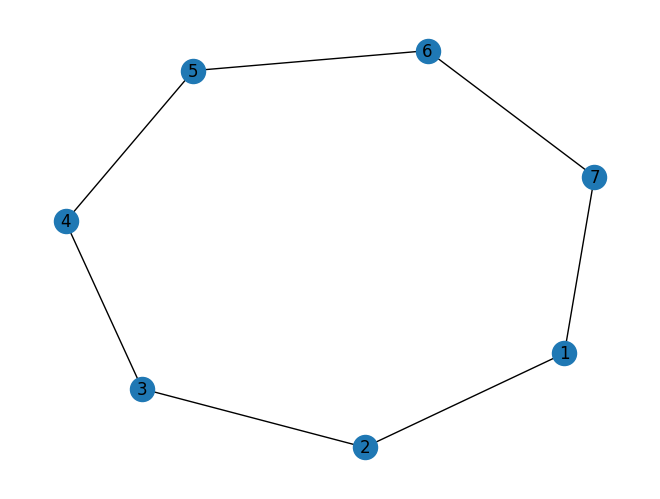

[14, 7, 14, 15, 11, 7, 7]
0.37276409521254406
[5, 10, 10, 10, 10]
0.3476816955607569
[5, 5, 10, 10, 10]
0.33164903450652705
[5, 5, 5, 10, 10]
0.3059151851670055
[5, 5, 5, 5, 10]
0.2849819072467913
[5, 5, 5, 5, 5]
GGGGGGGGGG.
0.2708333333333333
[5, 5, 5, 1]
0.2588888888888889
[5, 5, 1, 1]
0.25333333333333335
[5, 1, 1, 1]
Iter 0 done
R: [5, 1, 1, 1]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4)]
0.2513888888888889
[1, 1, 1, 1]
.GGGGGGGGGG.
Iter 1 done
R: [1, 1, 1]
G edges: [(1, 2), (1, 5), (3, 4)]
..
Iter 0 done
R: [1, 1, 1]
G edges: [(1, 2), (1, 5), (3, 4)]
..
Iter 1 done
R: [1, 1, 1]
G edges: [(1, 2), (1, 5), (3, 4)]
..
Iter 2 done
R: [1, 1, 1]
G edges: [(1, 2), (1, 5), (3, 4)]
..
Iter 3 done
R: [1, 1, 1]
G edges: [(1, 2), (1, 5), (3, 4)]
..
Iter 4 done
R: [1, 1, 1]
G edges: [(1, 2), (1, 5), (3, 4)]
FOUND:::


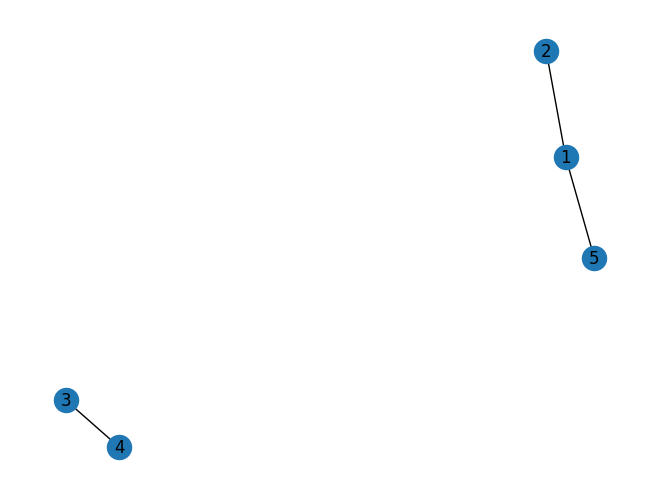

[1, 1, 1]
CR: 27.079316759682058
OR: 160400
PA: 6193
6000
Training model
LeNetTN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): TNLinearLayer(
    (layer): TN(
      (params): ParameterDict(
          (1): Parameter containing: [torch.cuda.FloatTensor of size 7x14x7 (cuda:0)]
          (2): Parameter containing: [torch.cuda.FloatTensor of size 7x14x14 (cuda:0)]
          (3): Parameter containing: [torch.cuda.FloatTensor of size 4x14x15 (cuda:0)]
          (4): Parameter containing: [torch.cuda.FloatTensor of size 4x15x11 (cuda:0)]
          (5): Parameter containing: [torch.cuda.FloatTensor of size 4x11x7 (cuda:0)]
          (6): Parameter containing: [torch.cuda.FloatTensor of size 9x7x7 (cuda:0)]
          (7): Parameter containing: [torch.cuda.FloatTensor of size 5x7x7 (cuda:0)]
      )
    )
  )
  (l2): TNLinearLayer(
    (layer): TN(
      (params): ParameterDict(
          (1): Parameter containing: [torch.cuda.FloatTensor of size 4x1x1 (cuda:0)]
          (2): Parameter

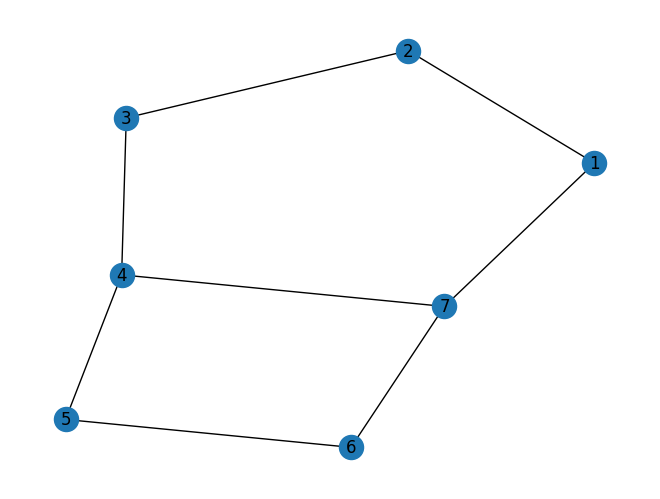

[15, 6, 23, 23, 11, 6, 11, 5]
0.5727103201312342
[5, 10, 10, 10, 10]
0.554382599085224
[5, 5, 10, 10, 10]
0.5486041854051094
[5, 5, 5, 10, 10]
0.5306864379510161
[5, 5, 5, 5, 10]
0.5169994741095518
[5, 5, 5, 5, 5]
GGGGGGGGGG.
0.5111111111111111
[5, 5, 1, 5]
0.5066666666666667
[5, 1, 1, 5]
Iter 0 done
R: [5, 1, 1, 5]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4)]
0.5047222222222222
[1, 1, 1, 5]
0.5012777777777778
[1, 1, 1, 1]
GGGGGGGGGG.
Iter 1 done
R: [1, 1, 1]
G edges: [(1, 5), (2, 3), (3, 4)]
..
Iter 0 done
R: [1, 1, 1]
G edges: [(1, 5), (2, 3), (3, 4)]
..
Iter 1 done
R: [1, 1, 1]
G edges: [(1, 5), (2, 3), (3, 4)]
..
Iter 2 done
R: [1, 1, 1]
G edges: [(1, 5), (2, 3), (3, 4)]
..
Iter 3 done
R: [1, 1, 1]
G edges: [(1, 5), (2, 3), (3, 4)]
..
Iter 4 done
R: [1, 1, 1]
G edges: [(1, 5), (2, 3), (3, 4)]
FOUND:::


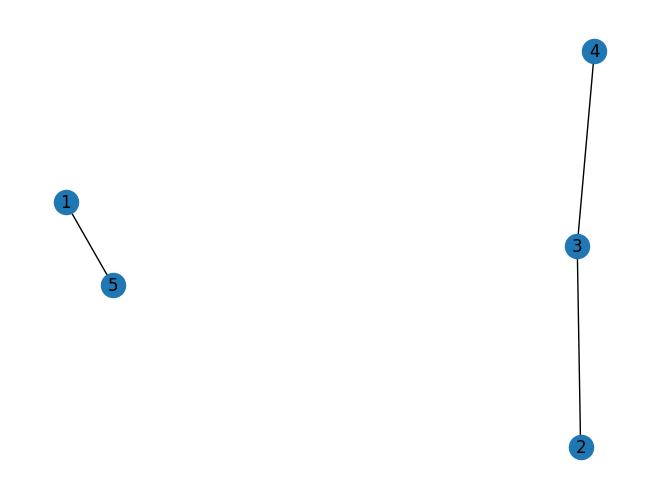

[1, 1, 1]
CR: 11.063359358806053
OR: 160400
PA: 14753
6000
Training model
LeNetTN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): TNLinearLayer(
    (layer): TN(
      (params): ParameterDict(
          (1): Parameter containing: [torch.cuda.FloatTensor of size 7x15x6 (cuda:0)]
          (2): Parameter containing: [torch.cuda.FloatTensor of size 7x15x23 (cuda:0)]
          (3): Parameter containing: [torch.cuda.FloatTensor of size 4x23x23 (cuda:0)]
          (4): Parameter containing: [torch.cuda.FloatTensor of size 4x23x11x6 (cuda:0)]
          (5): Parameter containing: [torch.cuda.FloatTensor of size 4x11x11 (cuda:0)]
          (6): Parameter containing: [torch.cuda.FloatTensor of size 9x11x5 (cuda:0)]
          (7): Parameter containing: [torch.cuda.FloatTensor of size 5x6x6x5 (cuda:0)]
      )
    )
  )
  (l2): TNLinearLayer(
    (layer): TN(
      (params): ParameterDict(
          (1): Parameter containing: [torch.cuda.FloatTensor of size 4x1 (cuda:0)]
          (2): Para

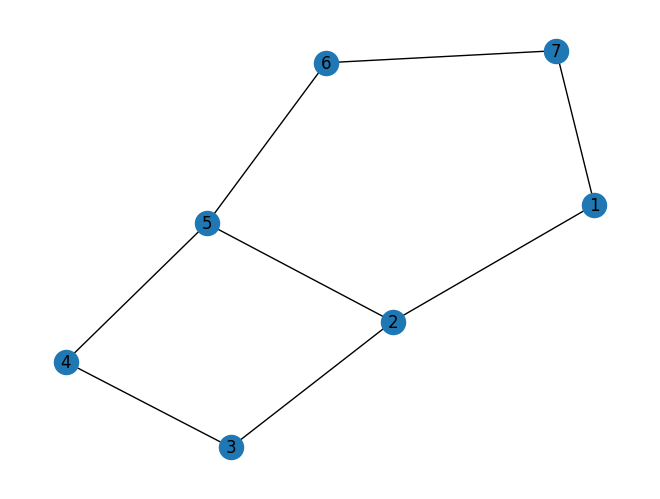

[11, 2, 11, 15, 6, 10, 10, 5]
0.7665945902017921
[10, 5, 10, 10, 10]
0.7635914066557156
[10, 5, 5, 10, 10]
0.7568530290475466
[10, 5, 5, 5, 10]
0.7537340425794198
[10, 5, 5, 5, 5]
GGGGGGGGGG.
Iter 0 done
R: [10, 5, 5, 5, 5]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4), (4, 5)]
0.7501179956887294
[5, 5, 5, 5, 5]
.GGGGGGGGGG.
Iter 1 done
R: [5, 5, 5, 5, 5]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4), (4, 5)]
..
Iter 0 done
R: [5, 5, 5, 5, 5]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4), (4, 5)]
..
Iter 1 done
R: [5, 5, 5, 5, 5]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4), (4, 5)]
..
Iter 2 done
R: [5, 5, 5, 5, 5]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4), (4, 5)]
..
Iter 3 done
R: [5, 5, 5, 5, 5]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4), (4, 5)]
..
Iter 4 done
R: [5, 5, 5, 5, 5]
G edges: [(1, 2), (1, 5), (2, 3), (3, 4), (4, 5)]
FOUND:::


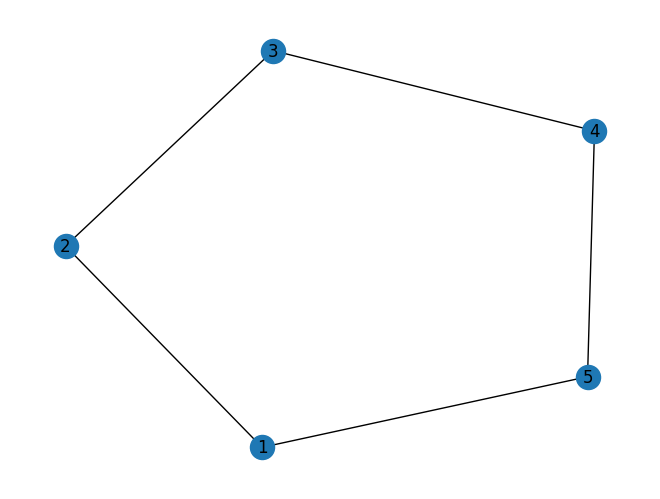

[5, 5, 5, 5, 5]
CR: 7.2334658474882545
OR: 160400
PA: 22416
6000
Training model
LeNetTN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): TNLinearLayer(
    (layer): TN(
      (params): ParameterDict(
          (1): Parameter containing: [torch.cuda.FloatTensor of size 7x11x2 (cuda:0)]
          (2): Parameter containing: [torch.cuda.FloatTensor of size 7x11x11x15 (cuda:0)]
          (3): Parameter containing: [torch.cuda.FloatTensor of size 4x11x6 (cuda:0)]
          (4): Parameter containing: [torch.cuda.FloatTensor of size 4x6x10 (cuda:0)]
          (5): Parameter containing: [torch.cuda.FloatTensor of size 4x15x10x10 (cuda:0)]
          (6): Parameter containing: [torch.cuda.FloatTensor of size 9x10x5 (cuda:0)]
          (7): Parameter containing: [torch.cuda.FloatTensor of size 5x2x5 (cuda:0)]
      )
    )
  )
  (l2): TNLinearLayer(
    (layer): TN(
      (params): ParameterDict(
          (1): Parameter containing: [torch.cuda.FloatTensor of size 4x5x5 (cuda:0)]
          (

<Figure size 640x480 with 0 Axes>

In [12]:
O1 = torch.reshape(model.l1.weight.detach(), S1 + S2)
O2 = torch.reshape(model.l2.weight.detach(), S2 + S3)
O3 = torch.reshape(model.l3.weight.detach(), S3 + S4)

train_infojobs = []

for tuning_param in [0.1, 0.25, 0.5, 0.75]:
    GG1, RR1 = TN.tn_ale(G1, R1, 5, 2, O1, print_iters=True, update_graph=True, tuning_param=tuning_param, max_rank=150)
    GG1, RR1 = TN.tn_ale(GG1, RR1, 5, 5, O1, print_iters=True, update_graph=False, tuning_param=tuning_param, max_rank=150)
    print("FOUND:::")
    nx.draw(GG1, with_labels=True)
    plt.savefig("results/nn/graph-" + str(tuning_param) + "-tnale-" + str(tuning_param) + "-RR1.png", format="PNG")
    plt.show()
    plt.clf()
    print(RR1)
    
    GG2, RR2 = TN.tn_ale(G2, R2, 5, 2, O2, print_iters=True, update_graph=True, tuning_param=tuning_param, max_rank=150)
    GG2, RR2 = TN.tn_ale(GG2, RR2, 5, 5, O2, print_iters=True, update_graph=False, tuning_param=tuning_param, max_rank=150)
    print("FOUND:::")
    nx.draw(GG2, with_labels=True)
    plt.savefig("results/nn/graph-" + str(tuning_param) + "-tnale-" + str(tuning_param) + "-RR2.png", format="PNG")
    plt.show()
    plt.clf()
    print(RR2)
    
    #GG3, RR3 = TN.tn_ale(G3, R3, 5, 2, O3, print_iters=True, update_graph=True, tuning_param=tuning_param, max_rank=150)
    #GG3, RR3 = TN.tn_ale(GG3, RR3, 5, 5, O3, print_iters=True, update_graph=False, tuning_param=tuning_param, max_rank=150)
    #print("FOUND:::")
    #nx.draw(GG3, with_labels=True)
    #plt.savefig("results/nn/graph-" + str(tuning_param) + "-tnale-" + str(tuning_param) + "-RR3.png", format="PNG")
    #plt.show()
    #plt.clf()
    #print(RR3)
    
    m3 = LeNetTN("LeNetTN+ALE-" + str(tuning_param), [GG1, GG2, G3], [RR1, RR2, R3], [S1, S2, S3, S4])
    print("CR: " + str(m3.get_cr()))
    print("OR: " + str(m3.n_info["ori_params"] + 280))
    print("PA: " + str(m3.n_info["t_params"] + 280))
    
    train_data = get_train_data()
    train_infojobs.append(train_model(m3, device, train_data, epochs=epochs))
# show_training_infos(training_infos, epochs)